In [18]:
import pandas as pd
import numpy as np
import pickle

In [19]:
with open("../../data/mat_grades.pickle", "rb") as fp:
    data = pickle.load(fp)

In [20]:
# Remove groups with no observations

In [21]:
data = list(filter(lambda x: len(x) > 0, data))
len(data)

1048

In [22]:
np.std(out[(out > 6.5) & (out < 7.5)])

0.24401333684055146

In [23]:
np.exp(- 0.5**2 / (2 * 0.3 ** 2))

0.24935220877729622

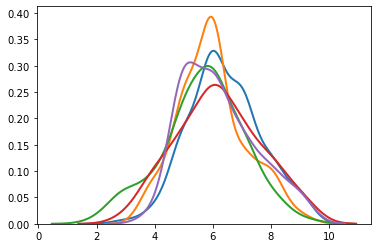

In [28]:
import seaborn as sns

fig = plt.figure()

sorted_by_len = np.argsort(np.array([len(x) for x in data]))[::-1]

for i in range(5):
    sns.kdeplot(data[sorted_by_len[i]], lw=2)
    
plt.ylabel("")
    
plt.savefig("example_invalsi.pdf", bbox_inches="tight")

In [26]:
data[463]

array([4.91130701, 4.0446036 , 4.07717212, 4.93808601])

In [5]:
# pad with nans

maxlen = np.max([len(x) for x in data])
out = np.empty((len(data), maxlen))
out[:, :] = np.nan

for i in range(len(data)):
    k = len(data[i])
    out[i, :k] = data[i] + np.random.normal(size=len(data[i])) * 0.25

(array([ 33., 218., 506., 226.,  36.,  17.,   8.,   2.,   1.,   1.]),
 array([  4. ,  16.7,  29.4,  42.1,  54.8,  67.5,  80.2,  92.9, 105.6,
        118.3, 131. ]),
 <BarContainer object of 10 artists>)

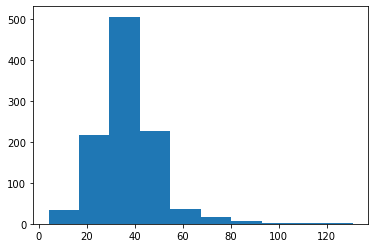

In [6]:
import matplotlib.pyplot as plt

plt.hist([len(x) for x in data])

In [10]:
np.max([len(x) for x in data])

131

In [69]:
with open("math_grades.pickle", "wb") as fp:
    pickle.dump(out, fp)

In [7]:
from jax import jit
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions


@jit
def get_mean_and_var(alldata, clus_idx, c):
    card = jnp.count_nonzero(clus_idx == c)
    ybar = jnp.where(clus_idx == c, alldata, 0).sum() / card
    var = jnp.where(clus_idx == c, (alldata - ybar)**2, 0).sum() / card
    return ybar, var


@jit
def norm_lpdf(data, atoms):
    means = jnp.vstack([x[0] for x in atoms])
    sds = jnp.sqrt(jnp.vstack([x[1] for x in atoms]))
    
    return tfd.Normal(means[:, jnp.newaxis], sds[:, jnp.newaxis]).log_prob(data).T

/opt/homebrew/Caskroom/miniconda/base/envs/scipy-dev/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [22]:
clus = np.random.choice(10, size=out.shape)
clus[np.isnan(out)] = -10
c = 2

In [23]:
alldata = jnp.array(out)
clus = jnp.array(clus)

get_mean_and_var(alldata, clus, c)

(DeviceArray(6.019065, dtype=float32), DeviceArray(2.098379, dtype=float32))

In [52]:
from jax import random
from jax.ops import index_update

seed = 0
key = random.PRNGKey(seed)

atoms = jnp.array(np.random.uniform(size=(10, 2)))
likes = norm_lpdf(alldata, atoms)
probas = jnp.exp(likes)
probas /= jnp.nansum(probas, axis=1)[:, jnp.newaxis, :]
rng_key, subkey = random.split(key)
clus = tfd.Categorical(probs=probas).sample(seed=key).T
clus = index_update(clus, np.isnan(alldata), -10)

In [63]:
from jax.ops import index

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [35]:
alldata.shape

(1048, 131)

In [30]:
likes.shape

(131, 1048, 10)